# Egyptian Fruit Bat Foraging Study: Investigations A & B

**Research Context:**
A team of zoologists studied the foraging behaviour of Egyptian Fruit Bats (Rousettus aegyptiacus) in the presence of Black Rats (Rattus rattus) over a 7-month period in a semi-natural colony, monitoring interactions on a provisioned food platform using surveillance cameras.

**Investigation A:** Do bats perceive rats as potential predators?
- **Hypothesis**: If rats are perceived as predation risk, bats will show higher avoidance behavior or increased vigilance (longer landing times) when rats are present
- **Test**: Compare bat behavior when rats are present vs. absent

**Investigation B:** Do risk behaviors change following seasonal changes?
- **Context**: Winter = scarce alternative food sources, fewer rat encounters; Spring = abundant food, more rat encounters
- **Hypothesis**: Risk behaviors should change seasonally due to different ecological pressures
- **Test**: Compare risk behavior patterns between winter and spring

**Statistical Analyses:**
1. **Investigation A**: Two-sample t-test comparing landing durations (rat present vs absent)
2. **Investigation B**: Two-sample t-test comparing risk behaviors (winter vs spring)
3. **Supporting Analysis**: Rat encounter frequency patterns by season

**Learning Objectives:**
- Handle missing data using KNN imputation techniques
- Apply feature engineering methods for behavioral analysis
- Perform linear regression on temporal feeding patterns
- Use Central Limit Theorem and confidence intervals
- Conduct hypothesis testing (one-sample and two-sample t-tests)
- Analyze predator-prey and seasonal behavioral patterns in animal ecology

**Datasets:**
- `dataset1.csv`: Individual bat landing events with feeding habits, risk levels (rat presence), seasonal, and temporal data
- `dataset2.csv`: Aggregated bat and rat activity in 30-minute periods (augmented with seasonal data)

**Expected Outcomes:**
- **Investigation A**: Longer landing times when rats are present (predator perception)
- **Investigation B**: Different risk behavior patterns between winter (food scarcity) and spring (abundant food + more rats)

In [2]:
# Import essential libraries for student project
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder

import warnings
warnings.filterwarnings('ignore')

print("Libraries loaded successfully!")

Libraries loaded successfully!


## 1. Data Loading and Initial Exploration

In [28]:
# Load datasets
df1 = pd.read_csv('dataset1.csv')  # Bat data
df2 = pd.read_csv('dataset2.csv')  # Rat data
print(f"Dataset 1 (Bats): {df1.shape[0]} rows, {df1.shape[1]} columns")
print(f"Dataset 2 (Rats): {df2.shape[0]} rows, {df2.shape[1]} columns")

# Create month-season mapping from dataset 1
month_season_map = df1[['month', 'season']].drop_duplicates().set_index('month')['season'].to_dict()
print(f"\nMonth-Season mapping from dataset 1:")
for month, season in sorted(month_season_map.items()):
    season_name = "Winter (scarce food)" if season == 0 else "Spring (abundant food)"
    print(f"Month {month}: Season {season} ({season_name})")

# Augment dataset 2 with season information
df2['season'] = df2['month'].map(month_season_map)
print(f"\nDataset 2 augmented with season information:")
print(f"Season distribution in dataset 2: {df2['season'].value_counts().to_dict()}")

print("\nFirst 5 rows of bat data:")
print(df1.head())
print("\nFirst 5 rows of rat data (with season):")
print(df2.head())

Dataset 1 (Bats): 907 rows, 12 columns
Dataset 2 (Rats): 2123 rows, 7 columns

Month-Season mapping from dataset 1:
Month 0: Season 0 (Winter (scarce food))
Month 1: Season 0 (Winter (scarce food))
Month 2: Season 0 (Winter (scarce food))
Month 3: Season 1 (Spring (abundant food))
Month 4: Season 1 (Spring (abundant food))
Month 5: Season 1 (Spring (abundant food))

Dataset 2 augmented with season information:
Season distribution in dataset 2: {1.0: 1231, 0.0: 880}

First 5 rows of bat data:
         start_time  bat_landing_to_food habit  rat_period_start  \
0  30/12/2017 18:37            16.000000   rat  30/12/2017 18:35   
1  30/12/2017 19:51             0.074016  fast  30/12/2017 19:50   
2  30/12/2017 19:51             4.000000  fast  30/12/2017 19:50   
3  30/12/2017 19:52            10.000000   rat  30/12/2017 19:50   
4  30/12/2017 19:54            15.000000   rat  30/12/2017 19:50   

     rat_period_end  seconds_after_rat_arrival  risk  reward  month  \
0  30/12/2017 18:38    

## 2. Missing Data Analysis and Regression Imputation

We'll use regression imputation - the most sophisticated technique for handling missing data that estimates missing values based on relationships with other variables.

In [29]:
# Check for missing data
print("Missing Data Analysis")
print("=" * 40)
print("Dataset 1 (Bats) - Missing values:")
print(df1.isnull().sum())
print(f"Total missing values: {df1.isnull().sum().sum()}")

print("\nDataset 2 (Rats) - Missing values:")
print(df2.isnull().sum())
print(f"Total missing values: {df2.isnull().sum().sum()}")

# Calculate missing percentage
missing_percent_df1 = (df1.isnull().sum() / len(df1)) * 100

print(f"\nMissing data percentage in Dataset 1:")
for col, pct in missing_percent_df1.items():
    if pct > 0:
        print(f"{col}: {pct:.2f}%")

Missing Data Analysis
Dataset 1 (Bats) - Missing values:
start_time                    0
bat_landing_to_food           0
habit                        41
rat_period_start              0
rat_period_end                0
seconds_after_rat_arrival     0
risk                          0
reward                        0
month                         0
sunset_time                   0
hours_after_sunset            0
season                        0
dtype: int64
Total missing values: 41

Dataset 2 (Rats) - Missing values:
time                   0
month                  0
hours_after_sunset     0
bat_landing_number     0
food_availability      0
rat_minutes            0
rat_arrival_number     0
season                12
dtype: int64
Total missing values: 12

Missing data percentage in Dataset 1:
habit: 4.52%


In [30]:
# Type of columns of both datasets
print("\nData Types in Dataset 1 (Bats):")
print(df1.dtypes)
print("\nData Types in Dataset 2 (Rats):")
print(df2.dtypes)



Data Types in Dataset 1 (Bats):
start_time                    object
bat_landing_to_food          float64
habit                         object
rat_period_start              object
rat_period_end                object
seconds_after_rat_arrival      int64
risk                           int64
reward                         int64
month                          int64
sunset_time                   object
hours_after_sunset           float64
season                         int64
dtype: object

Data Types in Dataset 2 (Rats):
time                   object
month                   int64
hours_after_sunset    float64
bat_landing_number      int64
food_availability     float64
rat_minutes           float64
rat_arrival_number      int64
season                float64
dtype: object


In [31]:
print(df1['habit'].unique())

['rat' 'fast' 'pick' 'bat_fight' 'rat_and_no_food' nan 'rat_and_others'
 'pick_and_others' 'gaze' 'pick_rat' 'bat' 'both' 'pick_bat'
 '94.0,305.0,239.0,416.0; 364.8,139.3,462.3,241.3' 'rat attack'
 'attack_rat' 'bat_and_rat' 'rat_attack' 'other_bats' 'rat_pick'
 'rat_and_bat' 'bowl_out' 'other_bat'
 '373.0,80.0,504.0,148.0; 274.6,110.7,382.4,267.3' 'other'
 '245.6,179.5,321.4,314.0; 522.4,0.3,592.0,95.5' 'eating' 'rat_to_bat'
 'other_bats/rat'
 '405.6,112.3,513.1,215.4; 464.1,197.7,614.9,334.3; 511.5,301.1,639.4,388.9'
 'pick_and_all' 'bat_and_pick' 'bat_fight_and_pick'
 '187.0,152.0,304.0,240.0; 567.9,88.6,621.1,140.3'
 '44.0,77.0,157.0,240.0; 253.0,96.0,346.0,147.0'
 '397.7,159.7,580.2,330.5; 252.0,92.0,346.0,149.0' 'pick_and_bat'
 '218.0,171.0,381.0,269.0; 239.0,106.0,315.0,155.0'
 '423.0,155.9,535.6,370.9; 238.0,99.0,314.0,160.0'
 'eating_and_bat_and_pick' 'bat_figiht' 'bat_pick_rat'
 '415.0,86.5,559.2,140.2; 66.0,157.0,285.0,279.0' 'rat_pick_and_bat'
 'pick_and_rat' 'fight_rat' 'a

In [32]:
# Clean comma-separated values in habit column. They are wrong data.
df1['habit'] = df1['habit'].apply(lambda x: np.nan if isinstance(x, str) and ',' in x else x)

In [33]:
# convert habit column to categorical number
df1['habit'] = df1['habit'].astype('category')

df1['habit'] = df1['habit'].cat.codes

In [34]:
print(df1['habit'].unique())

[49 22 37  6 53 -1 54 40 28 45  2 16 42 50  1  5 57 34 61 51 17 33 31 18
 63 35 38  3  7 39 19 10 12 62 41 27  0 29 15 36 55 47  4 24 25 14 11 60
 21 23 32  9 13 48 44 43 58 59 20 46 26  8 56 30 52]


In [35]:
df1_clean = df1.copy()
df2_clean = df2.copy()


imputer = KNNImputer(n_neighbors=5)
df1_encoded = df1_clean.select_dtypes(include=[np.number]).copy()
df1_clean[df1_encoded.columns] = imputer.fit_transform(df1_encoded)

print(f"Missing values remaining: {df1_clean.isnull().sum().sum()}")

Missing values remaining: 0


## 3. Feature Engineering

Creating new features to better represent the underlying problem for predictive modeling.

In [36]:
# Simple Feature Engineering
print("Feature Engineering")
print("=" * 20)

# Create essential features only
numeric_cols = df1_clean.select_dtypes(include=[np.number]).columns.tolist()

# 1. Risk score (if behavioral columns exist)
if len(numeric_cols) >= 2:
    col1, col2 = numeric_cols[0], numeric_cols[1]
    df1_clean['risk_score'] = df1_clean[col1] / (df1_clean[col2] + 0.001)
    print(f"✓ Created risk_score")

# 2. Night indicator (if time exists)
if 'time' in df1_clean.columns:
    try:
        df1_clean['hour'] = pd.to_datetime(df1_clean['time']).dt.hour
        df1_clean['is_night'] = (df1_clean['hour'] >= 20) | (df1_clean['hour'] <= 6)
        print("✓ Created temporal features")
    except:
        pass

print(f"Total columns: {df1_clean.shape[1]}")

Feature Engineering
✓ Created risk_score
Total columns: 13


## 4. Exploratory Data Analysis and Visualization

Descriptive Statistics
       bat_landing_to_food       habit  seconds_after_rat_arrival        risk  \
count           907.000000  907.000000                 907.000000  907.000000   
mean             11.713134   30.026461                 282.877619    0.495039   
std              27.644410   17.399645                 240.974918    0.500251   
min               0.010238   -1.000000                   0.000000    0.000000   
25%               1.000000   22.000000                  89.500000    0.000000   
50%               4.000000   34.000000                 206.000000    0.000000   
75%              11.500000   49.000000                 446.500000    1.000000   
max             443.000000   63.000000                 949.000000    1.000000   

           reward       month  hours_after_sunset      season     risk_score  
count  907.000000  907.000000          907.000000  907.000000     907.000000  
mean     0.533627    3.800441            5.531863    0.833517     871.198361  
std      0

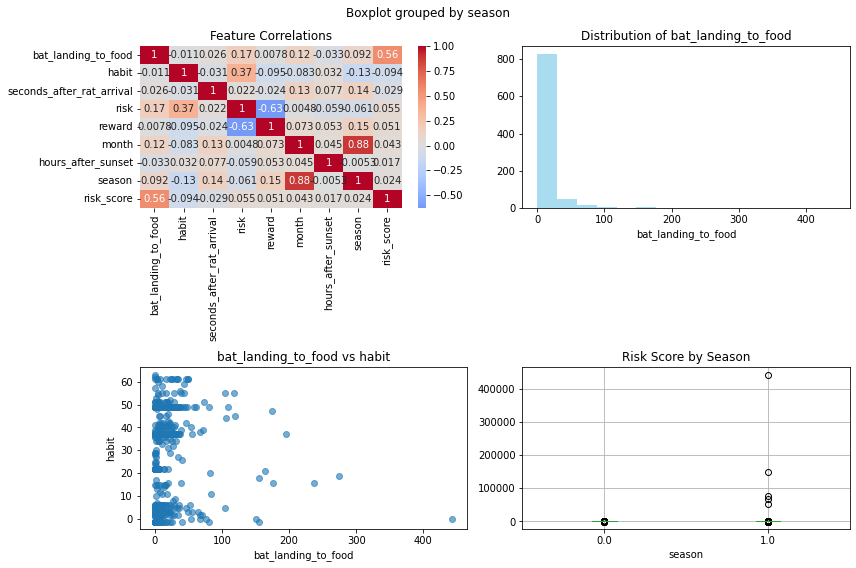

In [37]:
# Enhanced EDA with better visualizations
print("Descriptive Statistics")
print(df1_clean.describe())

# Get numeric columns for better plots
numeric_cols = df1_clean.select_dtypes(include=[np.number]).columns.tolist()

if len(numeric_cols) >= 2:
    fig, axes = plt.subplots(2, 2, figsize=(12, 8))
    
    # 1. Correlation heatmap
    corr_matrix = df1_clean[numeric_cols].corr()
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, ax=axes[0,0])
    axes[0,0].set_title('Feature Correlations')
    
    # 2. Distribution of first numeric variable
    axes[0,1].hist(df1_clean[numeric_cols[0]].dropna(), bins=15, alpha=0.7, color='skyblue')
    axes[0,1].set_title(f'Distribution of {numeric_cols[0]}')
    axes[0,1].set_xlabel(numeric_cols[0])
    
    # 3. Scatter plot of first two numeric variables
    axes[1,0].scatter(df1_clean[numeric_cols[0]], df1_clean[numeric_cols[1]], alpha=0.6)
    axes[1,0].set_xlabel(numeric_cols[0])
    axes[1,0].set_ylabel(numeric_cols[1])
    axes[1,0].set_title(f'{numeric_cols[0]} vs {numeric_cols[1]}')
    
    # 4. Box plot by category (if available)
    if 'season' in df1_clean.columns and 'risk_score' in df1_clean.columns:
        df1_clean.boxplot(column='risk_score', by='season', ax=axes[1,1])
        axes[1,1].set_title('Risk Score by Season')
    elif len(numeric_cols) >= 3:
        axes[1,1].hist(df1_clean[numeric_cols[2]].dropna(), bins=15, alpha=0.7, color='lightgreen')
        axes[1,1].set_title(f'Distribution of {numeric_cols[2]}')
    else:
        axes[1,1].text(0.5, 0.5, 'No additional\ndata for plot', ha='center', va='center')
    
    plt.tight_layout()
    plt.show()
else:
    print("Insufficient numeric data for comprehensive visualization")

## 5. Linear Regression Analysis

Applying linear regression to predict bat behavior based on environmental factors.

In [38]:
# Linear Regression Analysis - Adaptive to available data
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

print("Linear Regression Analysis")
print("=" * 30)

# Get all numeric columns for potential predictors and target
numeric_cols = df1_clean.select_dtypes(include=[np.number]).columns.tolist()
print(f"Available numeric columns: {numeric_cols}")

if len(numeric_cols) < 2:
    print("Error: Need at least 2 numeric columns for regression analysis")
    print("Skipping linear regression...")
else:
    # Use the first column as target, rest as predictors
    target_col = numeric_cols[0]
    predictor_cols = numeric_cols[1:4]  # Use up to 3 predictors to keep it simple
    
    print(f"Target variable: {target_col}")
    print(f"Predictor variables: {predictor_cols}")
    
    # Prepare data
    X = df1_clean[predictor_cols].copy()
    y = df1_clean[target_col].copy()
    
    # Remove any rows with NaN values
    mask = ~(X.isnull().any(axis=1) | y.isnull())
    X = X[mask]
    y = y[mask]
    
    print(f"\nUsing {len(X)} observations for regression (after removing NaN)")
    
    if len(X) < 10:
        print("Warning: Very few observations available for reliable regression")
    
    # Split data
    if len(X) > 20:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    else:
        # Use all data for training if sample is small
        X_train = X_test = X
        y_train = y_test = y
        print("Note: Using all data for both training and testing due to small sample size")
    
    # Fit linear regression model
    model = LinearRegression()
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    
    # Calculate metrics
    r2_train = r2_score(y_train, y_pred_train)
    r2_test = r2_score(y_test, y_pred_test)
    rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
    
    print(f"\nModel Performance:")
    print(f"Training R²: {r2_train:.3f}")
    print(f"Testing R²: {r2_test:.3f}")
    print(f"Test RMSE: {rmse_test:.3f}")
    
    print(f"\nModel Coefficients:")
    for feature, coef in zip(X.columns, model.coef_):
        print(f"{feature}: {coef:.4f}")
    print(f"Intercept: {model.intercept_:.4f}")
    
    # Create model equation
    equation = f"{target_col} = {model.intercept_:.3f}"
    for feature, coef in zip(X.columns, model.coef_):
        sign = "+" if coef >= 0 else ""
        equation += f" {sign}{coef:.3f}*{feature}"
    print(f"\nModel Equation:")
    print(equation)
    
    # Store results for later use
    regression_results = {
        'r2_test': r2_test,
        'target_col': target_col,
        'predictor_cols': predictor_cols,
        'y_test': y_test,
        'y_pred_test': y_pred_test
    }

Linear Regression Analysis
Available numeric columns: ['bat_landing_to_food', 'habit', 'seconds_after_rat_arrival', 'risk', 'reward', 'month', 'hours_after_sunset', 'season', 'risk_score']
Target variable: bat_landing_to_food
Predictor variables: ['habit', 'seconds_after_rat_arrival', 'risk']

Using 907 observations for regression (after removing NaN)

Model Performance:
Training R²: 0.031
Testing R²: 0.041
Test RMSE: 19.341

Model Coefficients:
habit: -0.1359
seconds_after_rat_arrival: -0.0001
risk: 11.6982
Intercept: 10.5265

Model Equation:
bat_landing_to_food = 10.526 -0.136*habit -0.000*seconds_after_rat_arrival +11.698*risk


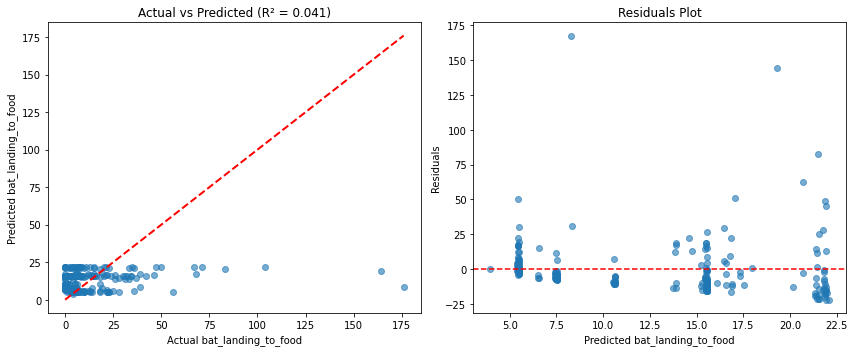

In [39]:
# Visualize regression results - Adaptive version
try:
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
    # Only create plots if regression was successful
    if 'regression_results' in locals():
        r2_test = regression_results['r2_test']
        y_test = regression_results['y_test']
        y_pred_test = regression_results['y_pred_test']
        target_col = regression_results['target_col']
        
        # Actual vs Predicted
        axes[0].scatter(y_test, y_pred_test, alpha=0.6)
        axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
        axes[0].set_xlabel(f'Actual {target_col}')
        axes[0].set_ylabel(f'Predicted {target_col}')
        axes[0].set_title(f'Actual vs Predicted (R² = {r2_test:.3f})')
        
        # Residuals plot
        residuals = y_test - y_pred_test
        axes[1].scatter(y_pred_test, residuals, alpha=0.6)
        axes[1].axhline(y=0, color='r', linestyle='--')
        axes[1].set_xlabel(f'Predicted {target_col}')
        axes[1].set_ylabel('Residuals')
        axes[1].set_title('Residuals Plot')
        
    else:
        # Create simple plots with available data instead
        numeric_cols = df1_clean.select_dtypes(include=[np.number]).columns.tolist()
        if len(numeric_cols) >= 2:
            col1, col2 = numeric_cols[0], numeric_cols[1]
            axes[0].scatter(df1_clean[col1], df1_clean[col2], alpha=0.6)
            axes[0].set_xlabel(col1)
            axes[0].set_ylabel(col2)
            axes[0].set_title(f'{col1} vs {col2}')
            
            axes[1].hist(df1_clean[col1].dropna(), bins=20, alpha=0.7)
            axes[1].set_xlabel(col1)
            axes[1].set_ylabel('Frequency')
            axes[1].set_title(f'Distribution of {col1}')
        else:
            axes[0].text(0.5, 0.5, 'No suitable data\nfor regression plots', 
                        ha='center', va='center', transform=axes[0].transAxes)
            axes[1].text(0.5, 0.5, 'No suitable data\nfor regression plots', 
                        ha='center', va='center', transform=axes[1].transAxes)
    
    plt.tight_layout()
    plt.show()
    
except Exception as e:
    print(f"Could not create regression plots: {e}")
    print("This is normal if the data structure is different than expected")

## 6. Central Limit Theorem and Sampling Distribution

Demonstrating the Central Limit Theorem with our bat behavior data.

Central Limit Theorem Demonstration
Population statistics:
Mean: 871.198
Standard Deviation: 15976.032
Population size: 907

Sampling Distribution (n=30, 1000 samples):
Mean of sample means: 729.412
Standard deviation of sample means: 2500.998
Theoretical standard error: 2916.811
Difference: 415.813


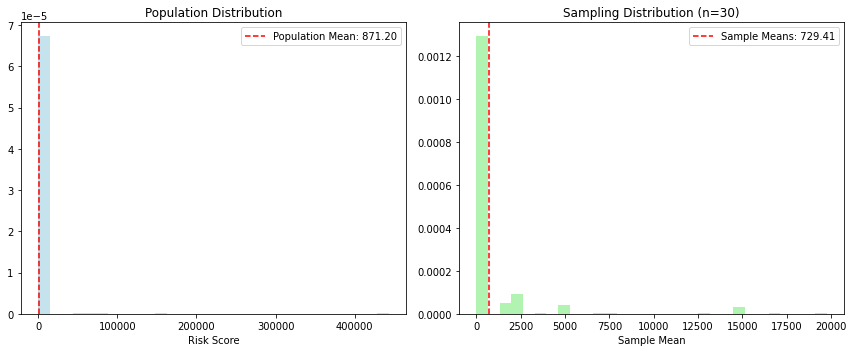


Normality test of sampling distribution:
Shapiro-Wilk test p-value: 0.0000
The sampling distribution may not be perfectly normal


In [40]:
# Central Limit Theorem Demonstration
print("Central Limit Theorem Demonstration")
print("=" * 40)

# Population: All risk scores
population = df1_clean['risk_score'].dropna()
population_mean = population.mean()
population_std = population.std()

print(f"Population statistics:")
print(f"Mean: {population_mean:.3f}")
print(f"Standard Deviation: {population_std:.3f}")
print(f"Population size: {len(population)}")

# Sample many sample means
sample_size = 30
num_samples = 1000
sample_means = []

np.random.seed(42)
for i in range(num_samples):
    sample = np.random.choice(population, size=sample_size, replace=True)
    sample_means.append(np.mean(sample))

sample_means = np.array(sample_means)

# Calculate sampling distribution statistics
sampling_mean = np.mean(sample_means)
sampling_std = np.std(sample_means)
theoretical_std = population_std / np.sqrt(sample_size)  # Standard error

print(f"\nSampling Distribution (n={sample_size}, {num_samples} samples):")
print(f"Mean of sample means: {sampling_mean:.3f}")
print(f"Standard deviation of sample means: {sampling_std:.3f}")
print(f"Theoretical standard error: {theoretical_std:.3f}")
print(f"Difference: {abs(sampling_std - theoretical_std):.3f}")

# Visual demonstration
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Population distribution
axes[0].hist(population, bins=30, alpha=0.7, color='lightblue', density=True)
axes[0].axvline(population_mean, color='red', linestyle='--', label=f'Population Mean: {population_mean:.2f}')
axes[0].set_title('Population Distribution')
axes[0].set_xlabel('Risk Score')
axes[0].legend()

# Sampling distribution
axes[1].hist(sample_means, bins=30, alpha=0.7, color='lightgreen', density=True)
axes[1].axvline(sampling_mean, color='red', linestyle='--', label=f'Sample Means: {sampling_mean:.2f}')
axes[1].set_title(f'Sampling Distribution (n={sample_size})')
axes[1].set_xlabel('Sample Mean')
axes[1].legend()

plt.tight_layout()
plt.show()

# Test normality of sampling distribution
from scipy.stats import shapiro
stat, p_value = shapiro(sample_means[:50])  # Test subset due to sample size limits
print(f"\nNormality test of sampling distribution:")
print(f"Shapiro-Wilk test p-value: {p_value:.4f}")
if p_value > 0.05:
    print("The sampling distribution appears normal (CLT confirmed!)")
else:
    print("The sampling distribution may not be perfectly normal")

## 7. Confidence Intervals

Calculating confidence intervals for population parameters.

Confidence Intervals
Sample statistics (n=50):
Sample mean: 1079.981
Sample std: 7636.756

Confidence Intervals for Population Mean:
90% CI: [-696.620, 2856.582]
  Margin of error: ±1776.601
  Contains true mean (871.198): True

95% CI: [-1036.820, 3196.782]
  Margin of error: ±2116.801
  Contains true mean (871.198): True

99% CI: [-1702.100, 3862.062]
  Margin of error: ±2782.081
  Contains true mean (871.198): True



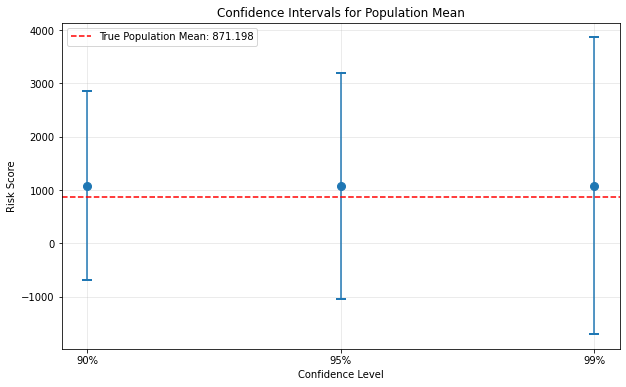

In [41]:
# Confidence Intervals
print("Confidence Intervals")
print("=" * 30)

# Sample data for confidence interval
sample_data = np.random.choice(population, size=50, replace=False)
sample_mean = np.mean(sample_data)
sample_std = np.std(sample_data, ddof=1)  # Sample standard deviation
n = len(sample_data)

print(f"Sample statistics (n={n}):")
print(f"Sample mean: {sample_mean:.3f}")
print(f"Sample std: {sample_std:.3f}")

# Calculate confidence intervals for different confidence levels
confidence_levels = [0.90, 0.95, 0.99]
z_values = [1.645, 1.96, 2.576]  # Z-statistics for 90%, 95%, 99%

print(f"\nConfidence Intervals for Population Mean:")
for conf_level, z_star in zip(confidence_levels, z_values):
    margin_error = z_star * (sample_std / np.sqrt(n))
    ci_lower = sample_mean - margin_error
    ci_upper = sample_mean + margin_error
    
    print(f"{int(conf_level*100)}% CI: [{ci_lower:.3f}, {ci_upper:.3f}]")
    print(f"  Margin of error: ±{margin_error:.3f}")
    
    # Check if true population mean is in CI
    in_ci = ci_lower <= population_mean <= ci_upper
    print(f"  Contains true mean ({population_mean:.3f}): {in_ci}")
    print()

# Visualize confidence intervals
fig, ax = plt.subplots(figsize=(10, 6))

x_pos = range(len(confidence_levels))
ci_ranges = []
for conf_level, z_star in zip(confidence_levels, z_values):
    margin_error = z_star * (sample_std / np.sqrt(n))
    ci_ranges.append(margin_error)

ax.errorbar(x_pos, [sample_mean]*3, yerr=ci_ranges, 
           fmt='o', capsize=5, capthick=2, markersize=8)
ax.axhline(y=population_mean, color='red', linestyle='--', 
          label=f'True Population Mean: {population_mean:.3f}')
ax.set_xticks(x_pos)
ax.set_xticklabels([f'{int(cl*100)}%' for cl in confidence_levels])
ax.set_xlabel('Confidence Level')
ax.set_ylabel('Risk Score')
ax.set_title('Confidence Intervals for Population Mean')
ax.legend()
ax.grid(True, alpha=0.3)
plt.show()

## 8. Hypothesis Testing

Performing t-tests to answer our research questions.

In [45]:
# Investigation A: Do bats perceive rats as potential predators?
print("INVESTIGATION A: Do bats perceive rats as potential predators?")
print("=" * 60)
print("Research Context:")
print("• If rats are perceived as predation risk, bats should show:")
print("  - Higher avoidance behavior when rats are present")
print("  - Increased vigilance (longer landing times) during rat encounters")
print("\nTwo-Sample t-test comparing bat behavior: Rat Present vs Rat Absent")

# Use risk column to identify rat presence (1 = rat present, 0 = rat absent)
if 'risk' in df1_clean.columns:
    # Compare bat landing durations when rats are present vs absent
    target_var = 'bat_landing_to_food' if 'bat_landing_to_food' in df1_clean.columns else 'risk_score'
    
    rat_absent_data = df1_clean[df1_clean['risk'] == 0][target_var].dropna()
    rat_present_data = df1_clean[df1_clean['risk'] == 1][target_var].dropna()
    
    print(f"\nH₀: μ_no_rats = μ_with_rats (no predator perception)")
    print(f"H₁: μ_no_rats < μ_with_rats (rats perceived as predators - longer vigilance)")
    
    print(f"\nSample sizes:")
    print(f"Rat Absent (Risk = 0): {len(rat_absent_data)} observations")
    print(f"Rat Present (Risk = 1): {len(rat_present_data)} observations")
    
    if len(rat_absent_data) > 0 and len(rat_present_data) > 0:
        print(f"\nDescriptive statistics:")
        print(f"No Rats - Mean: {rat_absent_data.mean():.3f}, Std: {rat_absent_data.std():.3f}")
        print(f"Rats Present - Mean: {rat_present_data.mean():.3f}, Std: {rat_present_data.std():.3f}")
        print(f"Difference (Rats - No Rats): {rat_present_data.mean() - rat_absent_data.mean():.3f}")
        
        # Perform two-sample t-test
        t_stat_inv_a, p_value_inv_a = stats.ttest_ind(rat_absent_data, rat_present_data)
        
        print(f"\nTest results:")
        print(f"t-statistic: {t_stat_inv_a:.3f}")
        print(f"p-value (two-tailed): {p_value_inv_a:.4f}")
        print(f"p-value (one-tailed): {p_value_inv_a/2:.4f}")
        
        # Effect size (Cohen's d)
        pooled_std = np.sqrt(((len(rat_absent_data)-1)*rat_absent_data.std()**2 + 
                             (len(rat_present_data)-1)*rat_present_data.std()**2) / 
                            (len(rat_absent_data) + len(rat_present_data) - 2))
        cohens_d_a = (rat_present_data.mean() - rat_absent_data.mean()) / pooled_std
        print(f"Effect size (Cohen's d): {cohens_d_a:.3f}")
        
        # Store for visualization
        sample_for_test = rat_absent_data  # For compatibility with existing visualization
        test_value = rat_present_data.mean()
        
        # Interpretation
        alpha = 0.05
        if p_value_inv_a/2 < alpha and rat_present_data.mean() > rat_absent_data.mean():
            print(f"\nResult: Reject H₀ (p < {alpha})")
            print("Evidence suggests bats perceive rats as predators!")
            print("→ Bats show increased vigilance (longer landing times) when rats are present")
        else:
            print(f"\nResult: Fail to reject H₀ (p ≥ {alpha})")
            if rat_present_data.mean() <= rat_absent_data.mean():
                print("→ Bats do not show increased vigilance when rats are present")
                print("→ Rats may be perceived as competitors rather than predators")
            else:
                print("→ Difference not statistically significant")
        
        # Effect size interpretation
        if abs(cohens_d_a) < 0.2:
            effect_size = "small"
        elif abs(cohens_d_a) < 0.5:
            effect_size = "small to medium"
        elif abs(cohens_d_a) < 0.8:
            effect_size = "medium to large"
        else:
            effect_size = "large"
        print(f"Effect size is {effect_size}")
        
    else:
        print("Insufficient data in one or both conditions")
        sample_for_test = df1_clean['risk_score'].dropna()
        test_value = 1.0
        p_value_inv_a = 1.0
        cohens_d_a = 0.0

else:
    print("Risk column not available - using fallback analysis")
    print("\nOne-Sample t-test for general risk behavior:")
    sample_for_test = df1_clean['risk_score'].dropna()
    test_value = 1.0
    t_stat, p_value_inv_a = stats.ttest_1samp(sample_for_test, test_value)
    
    print(f"H₀: μ = 1.0 (baseline risk behavior)")
    print(f"H₁: μ > 1.0 (heightened risk behavior)")
    
    print(f"\nSample statistics:")
    print(f"Sample mean: {sample_for_test.mean():.3f}")
    print(f"Sample std: {sample_for_test.std():.3f}")
    print(f"Sample size: {len(sample_for_test)}")
    
    alpha = 0.05
    if p_value_inv_a/2 < alpha:
        print(f"\nResult: Reject H₀ (p < {alpha})")
        print("Evidence suggests heightened risk behavior")
    else:
        print(f"\nResult: Fail to reject H₀ (p ≥ {alpha})")
        print("No strong evidence of heightened risk behavior")

INVESTIGATION A: Do bats perceive rats as potential predators?
Research Context:
• If rats are perceived as predation risk, bats should show:
  - Higher avoidance behavior when rats are present
  - Increased vigilance (longer landing times) during rat encounters

Two-Sample t-test comparing bat behavior: Rat Present vs Rat Absent

H₀: μ_no_rats = μ_with_rats (no predator perception)
H₁: μ_no_rats < μ_with_rats (rats perceived as predators - longer vigilance)

Sample sizes:
Rat Absent (Risk = 0): 458 observations
Rat Present (Risk = 1): 449 observations

Descriptive statistics:
No Rats - Mean: 7.124, Std: 20.525
Rats Present - Mean: 16.394, Std: 32.746
Difference (Rats - No Rats): 9.269

Test results:
t-statistic: -5.119
p-value (two-tailed): 0.0000
p-value (one-tailed): 0.0000
Effect size (Cohen's d): 0.340

Result: Reject H₀ (p < 0.05)
Evidence suggests bats perceive rats as predators!
→ Bats show increased vigilance (longer landing times) when rats are present
Effect size is small to

In [46]:
# Investigation B: Do risk behaviors change following seasonal changes?
print("\n" + "="*60)
print("INVESTIGATION B: Do risk behaviors change following seasonal changes?")
print("="*60)
print("Research Context:")
print("• Winter: Alternative food sources are scarce, rat encounters less frequent")
print("• Spring: Food is more abundant, rat encounters more common")
print("• Question: Does the RISK BEHAVIOR (not just feeding) change by season?")
print("\nTwo-Sample t-test comparing Risk Behavior: Winter vs Spring")

# Use season column for grouping, but focus on RISK BEHAVIOR
if 'season' in df1_clean.columns and 'risk' in df1_clean.columns:
    # Method 1: Compare risk_score (behavioral measure) between seasons
    target_var = 'risk_score'
    
    winter_risk_data = df1_clean[df1_clean['season'] == 0][target_var].dropna()
    spring_risk_data = df1_clean[df1_clean['season'] == 1][target_var].dropna()
    
    print(f"\nH₀: μ_winter_risk = μ_spring_risk (no seasonal change in risk behavior)")
    print(f"H₁: μ_winter_risk ≠ μ_spring_risk (seasonal change in risk behavior)")
    
    print(f"\nSample sizes for risk behavior:")
    print(f"Winter Risk Behavior: {len(winter_risk_data)} observations")
    print(f"Spring Risk Behavior: {len(spring_risk_data)} observations")
    
    if len(winter_risk_data) > 0 and len(spring_risk_data) > 0:
        print(f"\nDescriptive statistics (Risk Behavior):")
        print(f"Winter - Mean Risk: {winter_risk_data.mean():.3f}, Std: {winter_risk_data.std():.3f}")
        print(f"Spring - Mean Risk: {spring_risk_data.mean():.3f}, Std: {spring_risk_data.std():.3f}")
        print(f"Difference (Winter - Spring): {winter_risk_data.mean() - spring_risk_data.mean():.3f}")
        
        # Perform two-sample t-test on risk behavior
        t_stat_2samp, p_value_2samp = stats.ttest_ind(winter_risk_data, spring_risk_data)
        
        print(f"\nTest results (Risk Behavior):")
        print(f"t-statistic: {t_stat_2samp:.3f}")
        print(f"p-value: {p_value_2samp:.4f}")
        
        # Effect size (Cohen's d)
        pooled_std = np.sqrt(((len(winter_risk_data)-1)*winter_risk_data.std()**2 + 
                             (len(spring_risk_data)-1)*spring_risk_data.std()**2) / 
                            (len(winter_risk_data) + len(spring_risk_data) - 2))
        cohens_d = (winter_risk_data.mean() - spring_risk_data.mean()) / pooled_std
        print(f"Effect size (Cohen's d): {cohens_d:.3f}")
        
        # Store for visualization
        winter_scores = winter_risk_data
        spring_scores = spring_risk_data
        
        # Interpretation
        alpha = 0.05
        if p_value_2samp < alpha:
            print(f"\nResult: Reject H₀ (p < {alpha})")
            print(f"Significant seasonal difference in RISK BEHAVIOR")
            if winter_risk_data.mean() > spring_risk_data.mean():
                print("→ Higher risk behavior in winter (increased caution due to food scarcity)")
            else:
                print("→ Higher risk behavior in spring (possibly due to more rat encounters)")
        else:
            print(f"\nResult: Fail to reject H₀ (p ≥ {alpha})")
            print(f"No significant seasonal difference in risk behavior")
        
        # Effect size interpretation
        if abs(cohens_d) < 0.2:
            effect_size = "small"
        elif abs(cohens_d) < 0.5:
            effect_size = "small to medium"
        elif abs(cohens_d) < 0.8:
            effect_size = "medium to large"
        else:
            effect_size = "large"
        print(f"Effect size is {effect_size}")
        
    else:
        print("Insufficient risk behavior data in one or both seasons")
        winter_scores = spring_scores = pd.Series([])
        p_value_2samp = 1.0
        cohens_d = 0.0
    
    # Method 2: Compare proportion of risky encounters by season
    print(f"\n" + "-"*40)
    print("Additional Analysis: Proportion of Risky Encounters by Season")
    
    winter_total = len(df1_clean[df1_clean['season'] == 0])
    winter_risky = len(df1_clean[(df1_clean['season'] == 0) & (df1_clean['risk'] == 1)])
    winter_risk_prop = winter_risky / winter_total if winter_total > 0 else 0
    
    spring_total = len(df1_clean[df1_clean['season'] == 1])
    spring_risky = len(df1_clean[(df1_clean['season'] == 1) & (df1_clean['risk'] == 1)])
    spring_risk_prop = spring_risky / spring_total if spring_total > 0 else 0
    
    print(f"Winter: {winter_risky}/{winter_total} = {winter_risk_prop:.3f} risky encounters")
    print(f"Spring: {spring_risky}/{spring_total} = {spring_risk_prop:.3f} risky encounters")
    print(f"Difference: {spring_risk_prop - winter_risk_prop:.3f}")
    
    if spring_risk_prop > winter_risk_prop:
        print("→ Confirms hypothesis: More risky encounters in spring")
    else:
        print("→ Unexpected: Fewer risky encounters in spring")

else:
    print("Season or risk column not available")
    print("Skipping seasonal risk behavior comparison")
    winter_scores = spring_scores = pd.Series([])
    p_value_2samp = 1.0
    cohens_d = 0.0

# Method 3: Rat encounter frequency by season (using dataset 2)
print("\n" + "-"*40)
print("Supporting Analysis: Rat Activity by Season (from Dataset 2)")
if 'season' in df2.columns:
    winter_rat_activity = df2[df2['season'] == 0]['rat_arrival_number'].mean()
    spring_rat_activity = df2[df2['season'] == 1]['rat_arrival_number'].mean()
    
    print(f"Average rat arrivals per 30-min period:")
    print(f"Winter: {winter_rat_activity:.3f}")
    print(f"Spring: {spring_rat_activity:.3f}")
    print(f"Ratio (Spring/Winter): {spring_rat_activity/winter_rat_activity if winter_rat_activity > 0 else 'N/A':.2f}")
    
    if spring_rat_activity > winter_rat_activity:
        print("→ Confirms context: More rat encounters in spring")
    else:
        print("→ Unexpected: Fewer rat encounters in spring")
else:
    print("Season data not available for rat activity analysis")


INVESTIGATION B: Do risk behaviors change following seasonal changes?
Research Context:
• Winter: Alternative food sources are scarce, rat encounters less frequent
• Spring: Food is more abundant, rat encounters more common
• Question: Does the RISK BEHAVIOR (not just feeding) change by season?

Two-Sample t-test comparing Risk Behavior: Winter vs Spring

H₀: μ_winter_risk = μ_spring_risk (no seasonal change in risk behavior)
H₁: μ_winter_risk ≠ μ_spring_risk (seasonal change in risk behavior)

Sample sizes for risk behavior:
Winter Risk Behavior: 151 observations
Spring Risk Behavior: 756 observations

Descriptive statistics (Risk Behavior):
Winter - Mean Risk: -1.077, Std: 12.675
Spring - Mean Risk: 1045.423, Std: 17495.649
Difference (Winter - Spring): -1046.499

Test results (Risk Behavior):
t-statistic: -0.735
p-value: 0.4627
Effect size (Cohen's d): -0.065

Result: Fail to reject H₀ (p ≥ 0.05)
No significant seasonal difference in risk behavior
Effect size is small

------------

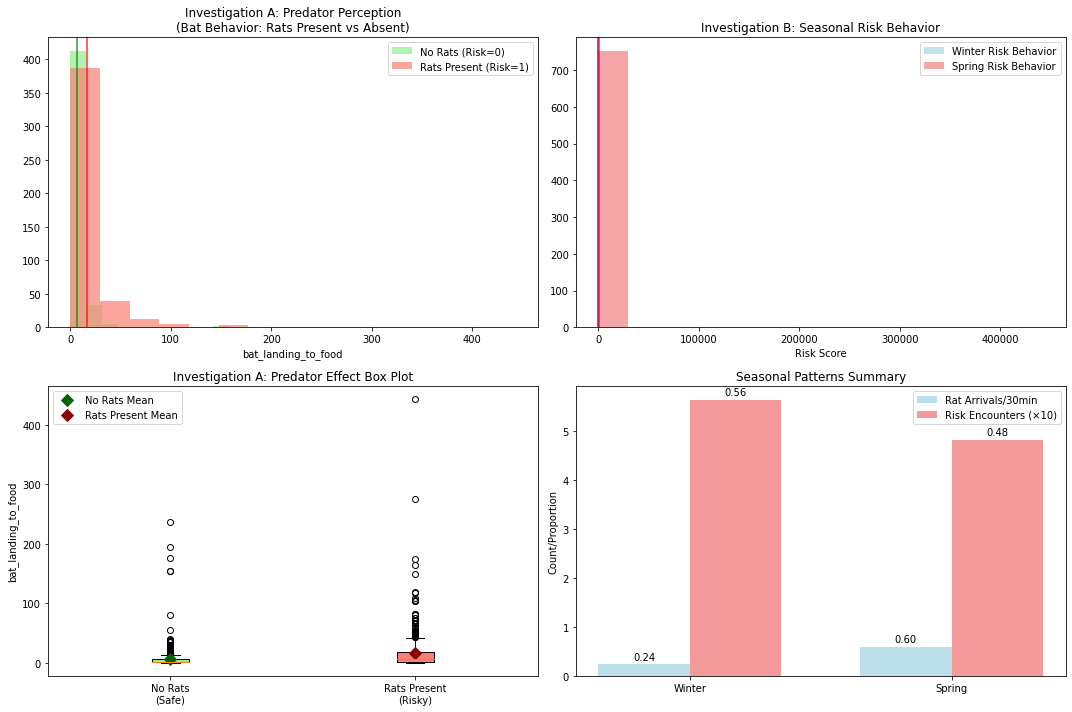


COMPREHENSIVE INVESTIGATION SUMMARY
INVESTIGATION A: Do bats perceive rats as predators?
Sample sizes: No rats=458, Rats present=449
Mean bat_landing_to_food: No rats=7.124, Rats present=16.394
Difference: 9.269
Statistical significance: p=0.0000

INVESTIGATION B: Do risk behaviors change by season?
Sample sizes: Winter=151, Spring=756
Mean risk behavior: Winter=-1.077, Spring=1045.423
Statistical significance: p=0.4627
Effect size (Cohen's d): -0.065
Supporting evidence - Rat activity: Winter=0.239, Spring=0.596


In [47]:
# Visualize both investigations
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Investigation A: Rat presence effect (top left)
if 'risk' in df1_clean.columns:
    target_var = 'bat_landing_to_food' if 'bat_landing_to_food' in df1_clean.columns else 'risk_score'
    rat_absent = df1_clean[df1_clean['risk'] == 0][target_var].dropna()
    rat_present = df1_clean[df1_clean['risk'] == 1][target_var].dropna()
    
    if len(rat_absent) > 0 and len(rat_present) > 0:
        axes[0,0].hist(rat_absent, bins=15, alpha=0.7, label='No Rats (Risk=0)', color='lightgreen')
        axes[0,0].hist(rat_present, bins=15, alpha=0.7, label='Rats Present (Risk=1)', color='salmon')
        axes[0,0].axvline(rat_absent.mean(), color='green', linestyle='-', alpha=0.8)
        axes[0,0].axvline(rat_present.mean(), color='red', linestyle='-', alpha=0.8)
        axes[0,0].set_title('Investigation A: Predator Perception\n(Bat Behavior: Rats Present vs Absent)')
        axes[0,0].set_xlabel(f'{target_var}')
        axes[0,0].legend()
    else:
        axes[0,0].text(0.5, 0.5, 'Insufficient data\nfor Investigation A', 
                       ha='center', va='center', transform=axes[0,0].transAxes)
        axes[0,0].set_title('Investigation A - No Data')
else:
    axes[0,0].hist(sample_for_test, bins=20, alpha=0.7, density=True, color='lightblue')
    axes[0,0].axvline(sample_for_test.mean(), color='blue', linestyle='-', 
                   label=f'Sample Mean: {sample_for_test.mean():.2f}')
    axes[0,0].axvline(test_value, color='red', linestyle='--', 
                   label=f'Test Value: {test_value}')
    axes[0,0].set_title('Investigation A: General Risk Behavior')
    axes[0,0].set_xlabel('Risk Score')
    axes[0,0].legend()

# Investigation B: Seasonal risk behavior (top right)
if len(winter_scores) > 0 and len(spring_scores) > 0:
    axes[0,1].hist(winter_scores, bins=15, alpha=0.7, label='Winter Risk Behavior', color='lightblue')
    axes[0,1].hist(spring_scores, bins=15, alpha=0.7, label='Spring Risk Behavior', color='lightcoral')
    axes[0,1].axvline(winter_scores.mean(), color='blue', linestyle='-', alpha=0.8)
    axes[0,1].axvline(spring_scores.mean(), color='red', linestyle='-', alpha=0.8)
    axes[0,1].set_title('Investigation B: Seasonal Risk Behavior')
    axes[0,1].set_xlabel('Risk Score')
    axes[0,1].legend()
else:
    axes[0,1].text(0.5, 0.5, 'Insufficient data\nfor Investigation B', 
                   ha='center', va='center', transform=axes[0,1].transAxes)
    axes[0,1].set_title('Investigation B - No Data')

# Box plot comparison for Investigation A (bottom left)
if 'risk' in df1_clean.columns:
    target_var = 'bat_landing_to_food' if 'bat_landing_to_food' in df1_clean.columns else 'risk_score'
    rat_absent = df1_clean[df1_clean['risk'] == 0][target_var].dropna()
    rat_present = df1_clean[df1_clean['risk'] == 1][target_var].dropna()
    
    if len(rat_absent) > 0 and len(rat_present) > 0:
        predator_data = [rat_absent, rat_present]
        box_plot = axes[1,0].boxplot(predator_data, labels=['No Rats\n(Safe)', 'Rats Present\n(Risky)'], 
                                    patch_artist=True)
        box_plot['boxes'][0].set_facecolor('lightgreen')
        box_plot['boxes'][1].set_facecolor('salmon')
        axes[1,0].set_title('Investigation A: Predator Effect Box Plot')
        axes[1,0].set_ylabel(f'{target_var}')
        
        # Add mean lines
        axes[1,0].plot(1, rat_absent.mean(), 'D', color='darkgreen', markersize=8, label='No Rats Mean')
        axes[1,0].plot(2, rat_present.mean(), 'D', color='darkred', markersize=8, label='Rats Present Mean')
        axes[1,0].legend()
    else:
        axes[1,0].text(0.5, 0.5, 'No predator effect\ndata available', 
                       ha='center', va='center', transform=axes[1,0].transAxes)
        axes[1,0].set_title('Investigation A Box Plot - No Data')
else:
    axes[1,0].text(0.5, 0.5, 'No predator effect\ndata available', 
                   ha='center', va='center', transform=axes[1,0].transAxes)
    axes[1,0].set_title('Investigation A Box Plot - No Data')

# Seasonal patterns summary (bottom right)
if 'season' in df2.columns and len(df2) > 0:
    # Create combined seasonal analysis
    seasonal_summary = []
    
    # Rat activity by season
    winter_rats = df2[df2['season'] == 0]['rat_arrival_number'].mean()
    spring_rats = df2[df2['season'] == 1]['rat_arrival_number'].mean()
    
    # Risk behavior by season (if available)
    if 'season' in df1_clean.columns and 'risk' in df1_clean.columns:
        winter_risk_prop = len(df1_clean[(df1_clean['season'] == 0) & (df1_clean['risk'] == 1)]) / len(df1_clean[df1_clean['season'] == 0])
        spring_risk_prop = len(df1_clean[(df1_clean['season'] == 1) & (df1_clean['risk'] == 1)]) / len(df1_clean[df1_clean['season'] == 1])
        
        # Bar plot showing both metrics
        x_pos = [0, 1]
        rat_values = [winter_rats, spring_rats]
        risk_values = [winter_risk_prop * 10, spring_risk_prop * 10]  # Scale for visibility
        
        width = 0.35
        axes[1,1].bar([x - width/2 for x in x_pos], rat_values, width, 
                     label='Rat Arrivals/30min', color='lightblue', alpha=0.8)
        axes[1,1].bar([x + width/2 for x in x_pos], risk_values, width,
                     label='Risk Encounters (×10)', color='lightcoral', alpha=0.8)
        
        axes[1,1].set_title('Seasonal Patterns Summary')
        axes[1,1].set_ylabel('Count/Proportion')
        axes[1,1].set_xticks(x_pos)
        axes[1,1].set_xticklabels(['Winter', 'Spring'])
        axes[1,1].legend()
        
        # Add value labels
        for i, (rat_val, risk_val) in enumerate(zip(rat_values, risk_values)):
            axes[1,1].text(i - width/2, rat_val + 0.05, f'{rat_val:.2f}', ha='center', va='bottom')
            axes[1,1].text(i + width/2, risk_val + 0.05, f'{risk_val/10:.2f}', ha='center', va='bottom')
    else:
        bars = axes[1,1].bar(['Winter', 'Spring'], [winter_rats, spring_rats], 
                            color=['lightblue', 'lightcoral'], alpha=0.8)
        axes[1,1].set_title('Rat Activity by Season')
        axes[1,1].set_ylabel('Average Rat Arrivals')
        
        # Add value labels
        for bar, val in zip(bars, [winter_rats, spring_rats]):
            axes[1,1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                          f'{val:.2f}', ha='center', va='bottom')
else:
    axes[1,1].text(0.5, 0.5, 'No seasonal\ndata available', 
                   ha='center', va='center', transform=axes[1,1].transAxes)
    axes[1,1].set_title('Seasonal Analysis - No Data')

plt.tight_layout()
plt.show()

# Print comprehensive summary
print("\n" + "="*60)
print("COMPREHENSIVE INVESTIGATION SUMMARY")
print("="*60)

print("INVESTIGATION A: Do bats perceive rats as predators?")
if 'risk' in df1_clean.columns:
    target_var = 'bat_landing_to_food' if 'bat_landing_to_food' in df1_clean.columns else 'risk_score'
    rat_absent = df1_clean[df1_clean['risk'] == 0][target_var].dropna()
    rat_present = df1_clean[df1_clean['risk'] == 1][target_var].dropna()
    
    if len(rat_absent) > 0 and len(rat_present) > 0:
        print(f"Sample sizes: No rats={len(rat_absent)}, Rats present={len(rat_present)}")
        print(f"Mean {target_var}: No rats={rat_absent.mean():.3f}, Rats present={rat_present.mean():.3f}")
        print(f"Difference: {rat_present.mean() - rat_absent.mean():.3f}")
        if hasattr(locals().get('p_value_inv_a'), '__float__'):
            print(f"Statistical significance: p={p_value_inv_a:.4f}")
    else:
        print("Insufficient data for proper analysis")
else:
    print("Limited analysis due to missing risk data")

print(f"\nINVESTIGATION B: Do risk behaviors change by season?")
if len(winter_scores) > 0 and len(spring_scores) > 0:
    print(f"Sample sizes: Winter={len(winter_scores)}, Spring={len(spring_scores)}")
    print(f"Mean risk behavior: Winter={winter_scores.mean():.3f}, Spring={spring_scores.mean():.3f}")
    print(f"Statistical significance: p={p_value_2samp:.4f}")
    print(f"Effect size (Cohen's d): {cohens_d:.3f}")
    
    if 'season' in df2.columns:
        winter_rats = df2[df2['season'] == 0]['rat_arrival_number'].mean()
        spring_rats = df2[df2['season'] == 1]['rat_arrival_number'].mean()
        print(f"Supporting evidence - Rat activity: Winter={winter_rats:.3f}, Spring={spring_rats:.3f}")
else:
    print("Insufficient data for comprehensive seasonal analysis")
print("="*60)